In [15]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.utils.layer_utils import count_params
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [16]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [17]:
train_path = 'data/cats-and-dogs/train'
valid_path = 'data/cats-and-dogs/valid'
test_path = 'data/cats-and-dogs/test'

In [18]:
train_batches = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)

Found 40 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [19]:
assert train_batches.n == 40
assert valid_batches.n == 16
assert test_batches.n == 10
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [20]:
# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [21]:
imgs, labels = next(train_batches)

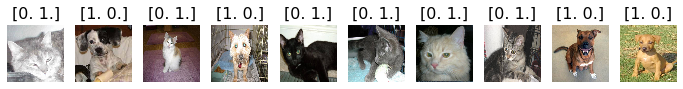

In [22]:
plots(imgs, titles=labels)

In [23]:
model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)),
        Flatten(),
        Dense(units=2, activation='softmax'),
    ])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1577088)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3154178   
Total params: 3,155,074
Trainable params: 3,155,074
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit_generator(generator=train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

C:\Users\Gaya3selva\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5


C:\Users\Gaya3selva\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\backend.py:4934: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [10,2] and labels shape [20]
	 [[node sparse_categorical_crossentropy/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\Gaya3selva\AppData\Roaming\Python\Python37\site-packages\keras\losses.py:246) ]] [Op:__inference_train_function_1279]

Function call stack:
train_function


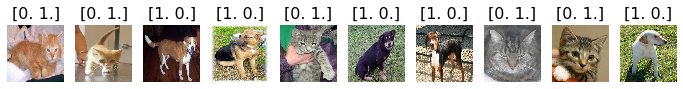

In [27]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [28]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 1., 1., 0., 1., 1., 0., 0., 1.], dtype=float32)

In [29]:
predictions = model.predict_generator(generator=test_batches, steps=1, verbose=0)

C:\Users\Gaya3selva\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [30]:
predictions

array([[1.00000000e+00, 7.62102390e-22],
       [1.00000000e+00, 0.00000000e+00],
       [1.40043310e-04, 9.99859929e-01],
       [1.00000000e+00, 1.11219603e-19],
       [1.00000000e+00, 4.93044747e-35],
       [1.00000000e+00, 1.16837205e-33],
       [1.00000000e+00, 3.09924088e-22],
       [1.00000000e+00, 6.81092398e-26],
       [1.00000000e+00, 3.96039511e-13],
       [1.00000000e+00, 1.25182533e-28]], dtype=float32)

In [31]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.round(predictions[:,0]))

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 5]
 [1 4]]


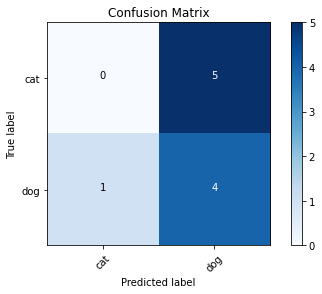

In [33]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [36]:
# Download model - Internet connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 221s 0us/step


In [37]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [43]:
# verify model params
assert count_params(vgg16_model.non_trainable_weights) == 0
assert count_params(vgg16_model.trainable_weights) == 138357544

In [44]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [45]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [46]:
# verify model params
assert count_params(model.non_trainable_weights) == 0
assert count_params(model.trainable_weights) == 134260544

ValueError: Weights for model sequential_4 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [47]:
for layer in model.layers:
    layer.trainable = False

In [48]:
model.add(Dense(units=2, activation='softmax'))

In [49]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [50]:
# verify model params
assert count_params(model.non_trainable_weights) == 134260544
assert count_params(model.trainable_weights) == 8194

ValueError: Weights for model sequential_4 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
model.fit_generator(generator=train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=10, verbose=2)

Epoch 1/10


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [10,2] and labels shape [20]
	 [[node sparse_categorical_crossentropy/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\Gaya3selva\AppData\Roaming\Python\Python37\site-packages\keras\losses.py:246) ]] [Op:__inference_train_function_3162]

Function call stack:
train_function


In [54]:
assert model.history.history.get('accuracy')[-1] > 0.85

TypeError: 'NoneType' object is not subscriptable

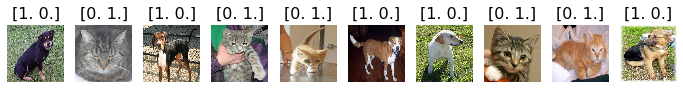

In [55]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [56]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 1., 0., 0., 1., 1., 0., 0., 1.], dtype=float32)

In [57]:
predictions = model.predict_generator(generator=test_batches, steps=1, verbose=0)

In [58]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.round(predictions[:,0]))

Confusion matrix, without normalization
[[3 2]
 [1 4]]


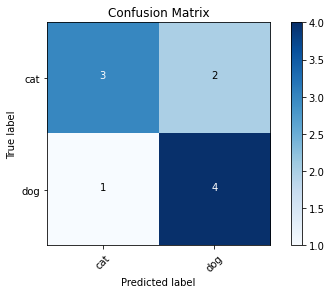

In [59]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')